In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import torch.nn as nn
import torch.nn.functional as F
from single_task.NoDA_base.relu_models import FeatureExtractor, LabelRegressor

from jupyter_utils import AllDataset

data_dir = '../drp-data/'
GDSC_GENE_EXPRESSION = 'preprocessed/gdsc_tcga/gdsc_rma_gene_expr.csv'
TCGA_GENE_EXPRESSION = 'preprocessed/gdsc_tcga/tcga_log2_gene_expr.csv'

TCGA_TISSUE = 'preprocessed/tissue_type/TCGA_tissue_one_hot.csv'
GDSC_TISSUE = 'preprocessed/tissue_type/GDSC_tissue_one_hot.csv'

GDSC_lnIC50 = 'preprocessed/drug_response/gdsc_lnic50.csv'
TCGA_DR = 'preprocessed/drug_response/tcga_drug_response.csv'

dataset = AllDataset(data_dir, GDSC_GENE_EXPRESSION, TCGA_GENE_EXPRESSION, 
                     GDSC_lnIC50, TCGA_DR, TCGA_TISSUE)

In [2]:
drug = 'tamoxifen'
gdsc_expr, gdsc_dr, train_tcga_expr, test_tcga_expr = dataset.filter_and_normalize_data(drug)

In [3]:
test_tissue = dataset.tcga_tissue.loc[test_tcga_expr.index]
tissue_list = [t for t in test_tissue.columns if test_tissue[t].sum() > 0]
test_tissue = test_tissue[tissue_list]

meta = pd.DataFrame(index=test_tcga_expr.index, columns=['tissue', 'label'])
for tissue in test_tissue.columns:
    x = test_tissue.loc[test_tissue[tissue] == 1].index
    meta.loc[x, 'tissue'] = tissue

meta['label'] = dataset.tcga_dr.loc[test_tcga_expr.index][drug]
print(test_tissue.sum(axis=0))

Breast         17
Soft Tissue     2
Skin            1
dtype: int64


In [4]:
from gene_finding.models import load_model, EnsModel

In [6]:
n_seeds = 10
models = []
outputs = pd.DataFrame(index=test_tcga_expr.index, columns=range(1,n_seeds+1))
x = torch.FloatTensor(test_tcga_expr.values)

for i in range(1, n_seeds+1):
    mod = load_model(seed=i,drug=drug,n_genes=len(dataset.genes))
    mod.eval()
    models.append(mod)
    outputs[i] = mod(x).detach().numpy()

In [7]:
model = EnsModel(models)

In [8]:
model.eval()
x = torch.FloatTensor(test_tcga_expr.values)
pred_test = model(x).detach().numpy()
pred_test = pd.Series(pred_test.reshape(-1), index=test_tcga_expr.index)

In [9]:
meta['pred'] = pred_test

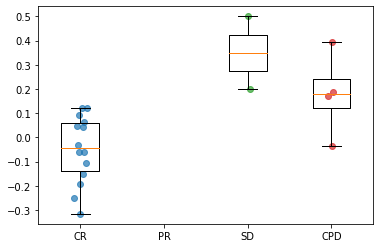

In [10]:
ctg = ["Complete Response", "Partial Response", "Stable Disease", "Clinical Progressive Disease"]
response = ['CR', 'PR', 'SD', 'CPD']

label = dataset.tcga_dr.loc[test_tcga_expr.index]
boxes = []
for c in ctg:
    x = label.loc[label[drug] == c].index
    boxes.append(pred_test[x])

fig, ax = plt.subplots()
ax.boxplot(boxes)    

for i, box in enumerate(boxes):
    y = box.values
    x = np.random.normal(i+1, 0.04, size=len(y))
    ax.scatter(x, y, alpha=0.7)

ax.set_xticklabels(response)
plt.show()

In [12]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
tf.random.set_seed(1)
from tensorflow.python.keras.losses import mean_squared_error as loss
from cxplain import MLPModelBuilder, CXPlain

In [13]:
model_builder = MLPModelBuilder(num_layers=2, num_units=512, batch_size=8, learning_rate=0.001)
explainer = CXPlain(model, model_builder, None, loss)
exp = explainer.load('gene_finding/results/CX_ens1/%s/explainer'%drug)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [15]:
attr = exp.explain(test_tcga_expr.values)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [17]:
attr = pd.DataFrame(attr, index=test_tcga_expr.index, columns=dataset.hgnc)

In [18]:
idx = '1e215a66-f961-4870-a370-4b945e1f7053.FPKM.txt.gz'

In [23]:
def plot_attr_vs_expr(attr, expr, all_ax, top_ax, title='Attribution vs Expression'):
    all_ax.scatter(expr, np.abs(attr), alpha=0.1)
    all_ax.set_ylabel("Attribution")
    all_ax.set_xlabel("Expression")
    scc, p = spearmanr(expr, attr)
    all_ax.set_title("%s (SCC: %.4f)"%(title, scc))

    top200 = np.abs(attr).nlargest(200).index
    top_ax.scatter(expr[top200], np.abs(attr[top200]), alpha=0.5)
    top_ax.set_ylabel("Attribution")
    top_ax.set_xlabel("Expression")
    scc, p = spearmanr(expr[top200], attr[top200])
    top_ax.set_title("Top 200 (SCC: %.4f)"%scc)

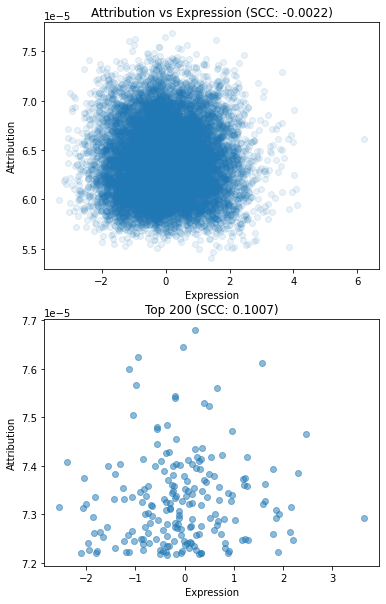

In [24]:
fig, ax = plt.subplots(2, 1, figsize=(6, 10))

plot_attr_vs_expr(attr.loc[idx], test_tcga_expr.loc[idx], ax[0], ax[1])

In [54]:
for i in attr.index:
    print(spearmanr(attr.loc[i], np.abs(test_tcga_expr.loc[i])))

SpearmanrResult(correlation=-0.008748470390170899, pvalue=0.27379413074424935)
SpearmanrResult(correlation=-0.0032396489072332043, pvalue=0.6852947547141915)
SpearmanrResult(correlation=0.05738686051609152, pvalue=6.748257070815771e-13)
SpearmanrResult(correlation=-0.015080795397664956, pvalue=0.059219062446507646)
SpearmanrResult(correlation=-0.005598043832668501, pvalue=0.48376206979886016)
SpearmanrResult(correlation=0.015956773559723435, pvalue=0.04591657910539791)
SpearmanrResult(correlation=0.004651667203206603, pvalue=0.5606474807675641)
SpearmanrResult(correlation=0.0011715816346077284, pvalue=0.8834847280068283)
SpearmanrResult(correlation=0.02387459067435936, pvalue=0.0028182421513754433)
SpearmanrResult(correlation=-0.011038287433600451, pvalue=0.16733398004350072)
SpearmanrResult(correlation=-0.03741382315977639, pvalue=2.8445986822094568e-06)
SpearmanrResult(correlation=0.03219930895367693, pvalue=5.6049147282340923e-05)
SpearmanrResult(correlation=6.675760936152582e-05, p

In [55]:
for i in attr.index:
    print(spearmanr(attr.loc[i], test_tcga_expr.loc[i]))

SpearmanrResult(correlation=0.030963537074051382, pvalue=0.0001069945563076253)
SpearmanrResult(correlation=0.00018442817897976513, pvalue=0.9815943440031206)
SpearmanrResult(correlation=0.03868669686564854, pvalue=1.2910297811668514e-06)
SpearmanrResult(correlation=0.003968391229336092, pvalue=0.6196066631092458)
SpearmanrResult(correlation=0.056564263198764, pvalue=1.42817274191349e-12)
SpearmanrResult(correlation=-0.013412430068627117, pvalue=0.09337913775235894)
SpearmanrResult(correlation=0.054342559685286784, pvalue=1.026508692800814e-11)
SpearmanrResult(correlation=0.04559234812128331, pvalue=1.1558566051418925e-08)
SpearmanrResult(correlation=0.0008969931581575987, pvalue=0.9106609696702499)
SpearmanrResult(correlation=0.0029414257531381986, pvalue=0.712915253169915)
SpearmanrResult(correlation=-0.0038606413469718056, pvalue=0.6291459363151279)
SpearmanrResult(correlation=0.021053496407774985, pvalue=0.008441703442467514)
SpearmanrResult(correlation=-0.020896456064322753, pvalu

**NOTE:** Attribution is not correlated with expression

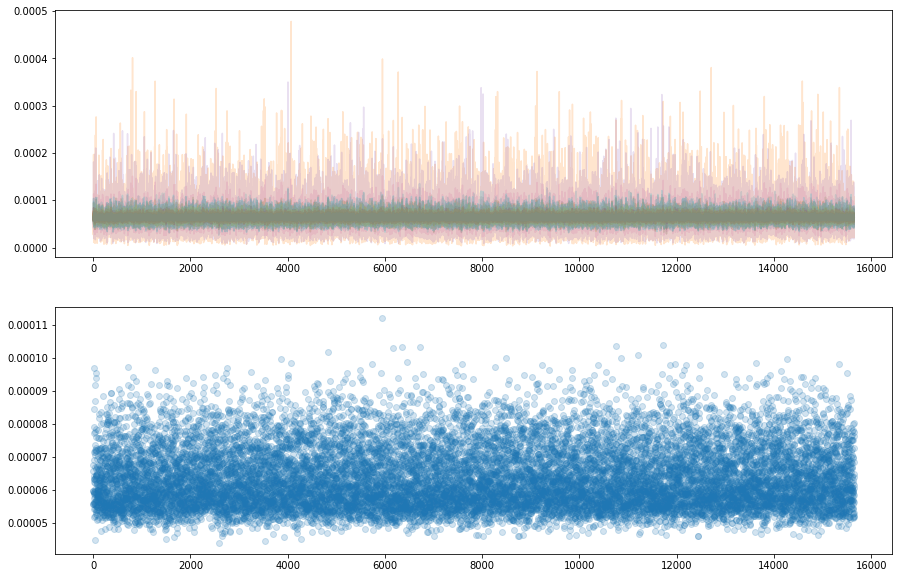

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))

for i in attr.index:
    ax[0].plot(range(len(dataset.hgnc)), attr.loc[i], alpha=0.2)
    
ax[1].scatter(range(len(dataset.hgnc)), np.abs(attr).mean(axis=0), alpha=0.2)

## Get Top 200 (mean and borda)

In [27]:
attr_mean = list(np.abs(attr).mean(axis=0).nlargest(200).index)

In [29]:
from gene_finding.borda import rank_aggregate_Borda
def get_ranked_list(attr, k=200):
    attr = np.abs(attr.T)
    sorted_list = []

    for sample in attr.columns:
        rank = attr.sort_values(sample, ascending=False).index # highest to lowest
        sorted_list.append(rank)

    agg_genes = rank_aggregate_Borda(sorted_list, k, 'geometric_mean')

    return agg_genes

In [30]:
borda = get_ranked_list(attr)

### Similarity of the top 200 genes in mean agg and borda agg

In [31]:
from sklearn.metrics import jaccard_score

In [35]:
mean_onehot = attr.columns.isin(attr_mean)*1
borda_onehot = attr.columns.isin(borda)*1

In [36]:
jaccard_score(mean_onehot, borda_onehot)

0.5325670498084292

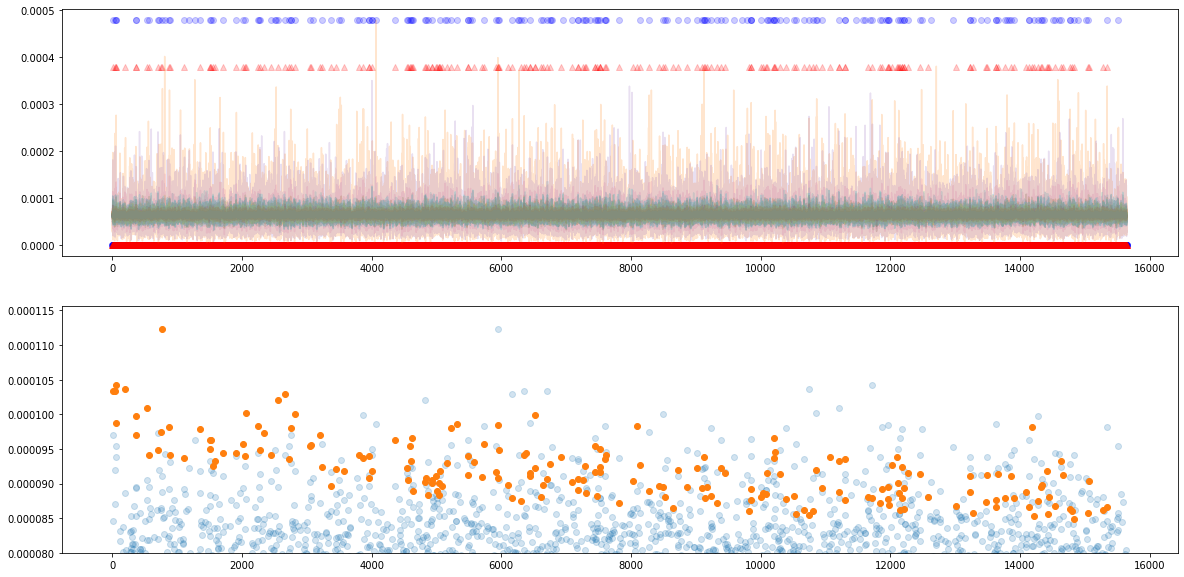

In [47]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

for i in attr.index:
    ax[0].plot(range(len(dataset.hgnc)), attr.loc[i], alpha=0.2)
ax[0].scatter(range(len(dataset.hgnc)), mean_onehot*attr.max().max(), alpha=0.2, color='b')
ax[0].scatter(range(len(dataset.hgnc)), borda_onehot*(attr.max().max()-0.0001), alpha=0.2, color='r', marker='^')
    
ax[1].scatter(range(len(dataset.hgnc)), np.abs(attr).mean(axis=0), alpha=0.2)

x_borda = [i for i, j in enumerate(borda_onehot) if j == 1]
y_borda = attr[borda].mean()
ax[1].scatter(x_borda, y_borda)
ax[1].set_ylim(bottom=0.00008)

plt.show()

**NOTE:** Should I be worried about the the index being a bit correlated with the mean attribution?

Text(0.5, 1.0, 'Mean Aggregation')

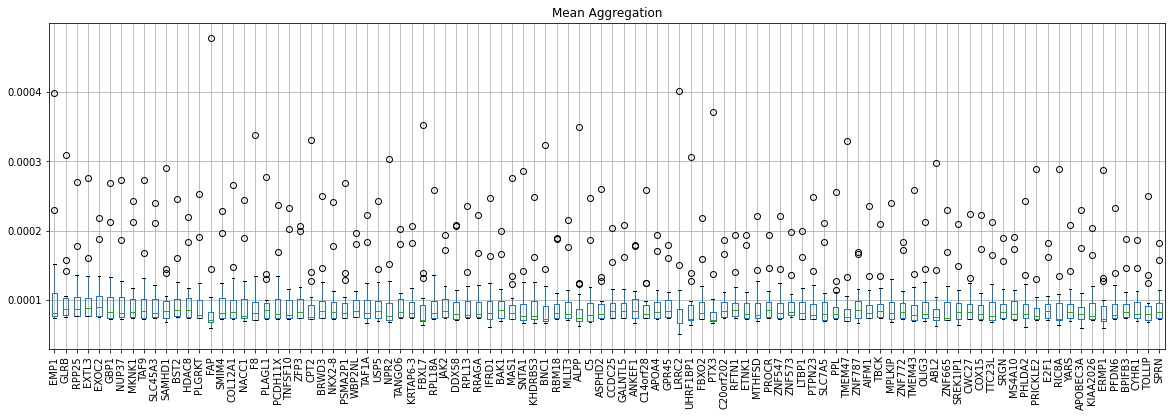

In [75]:
fig, ax = plt.subplots(figsize=(20, 6))
attr[attr_mean[:100]].boxplot(ax=ax, rot=90)
ax.set_title("Mean Aggregation")

Text(0.5, 1.0, 'Borda Aggregation')

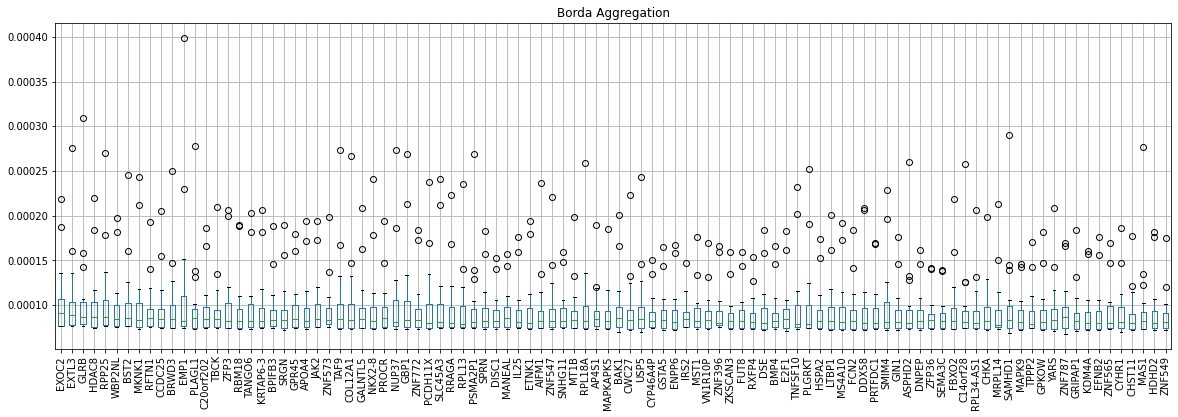

In [76]:
fig, ax = plt.subplots(figsize=(20, 6))
attr[borda[:100]].boxplot(ax=ax, rot=90)
ax.set_title("Borda Aggregation")

## GDSC

In [77]:
gdsc_attr = exp.explain(gdsc_expr.values)
gdsc_attr = pd.DataFrame(gdsc_attr, index=gdsc_expr.index, columns=dataset.hgnc)

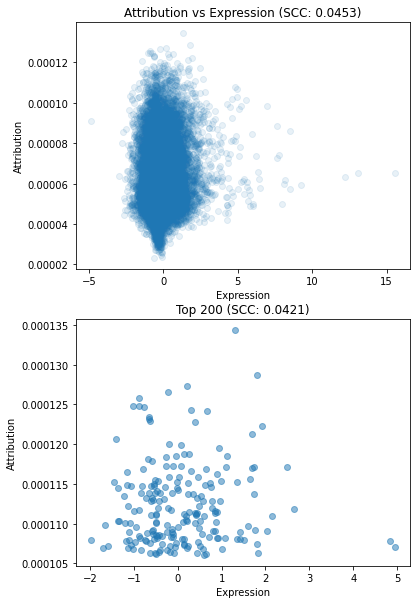

In [78]:
fig, ax = plt.subplots(2, 1, figsize=(6, 10))
idx = gdsc_expr.index[0]
plot_attr_vs_expr(gdsc_attr.loc[idx], gdsc_expr.loc[idx], ax[0], ax[1])

In [82]:
scc = []
for i in gdsc_attr.index:
    scc.append(spearmanr(gdsc_attr.loc[i], gdsc_expr.loc[i])[0])
print(np.asarray(scc).mean())

0.057093391854793736


In [83]:
gdsc_attr_mean = list(np.abs(gdsc_attr).mean(axis=0).nlargest(200).index)
gdsc_borda = get_ranked_list(gdsc_attr)

In [84]:
gdsc_mean_onehot = attr.columns.isin(gdsc_attr_mean)*1
gdsc_borda_onehot = attr.columns.isin(gdsc_borda)*1

In [85]:
jaccard_score(mean_onehot, borda_onehot)

0.5325670498084292

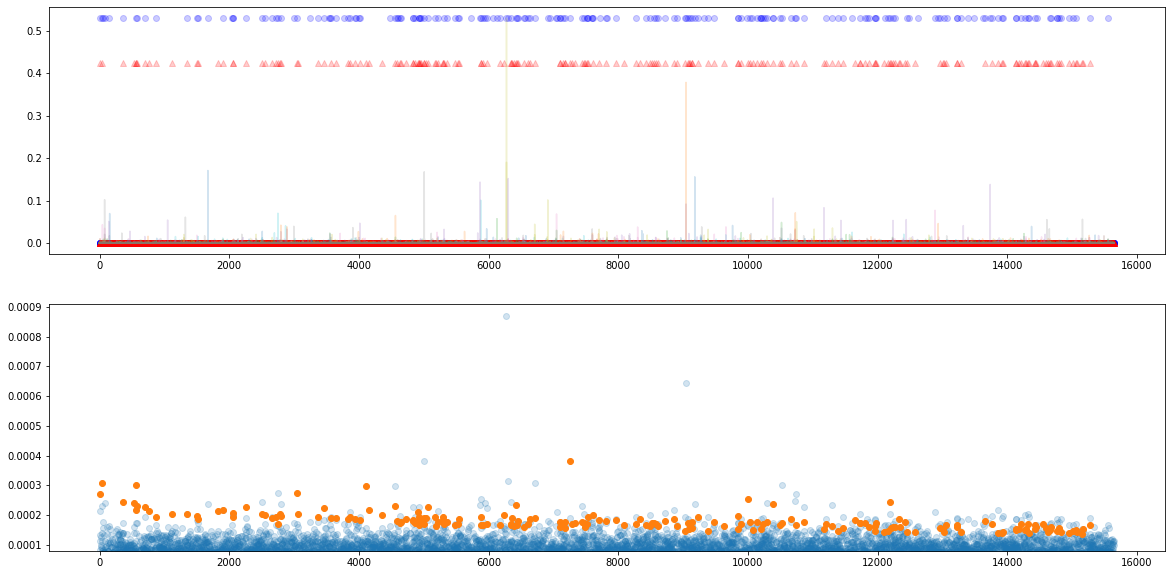

In [88]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

for i in gdsc_attr.index:
    ax[0].plot(range(len(dataset.hgnc)), gdsc_attr.loc[i], alpha=0.2)
ax[0].scatter(range(len(dataset.hgnc)), gdsc_mean_onehot*gdsc_attr.max().max(), alpha=0.2, color='b')
ax[0].scatter(range(len(dataset.hgnc)), gdsc_borda_onehot*(gdsc_attr.max().max()*0.8), alpha=0.2, color='r', marker='^')
    
ax[1].scatter(range(len(dataset.hgnc)), np.abs(gdsc_attr).mean(axis=0), alpha=0.2)

x_borda = [i for i, j in enumerate(gdsc_borda_onehot) if j == 1]
y_borda = gdsc_attr[gdsc_borda].mean()
ax[1].scatter(x_borda, y_borda)
ax[1].set_ylim(bottom=0.00008)

plt.show()

(0.0, 0.001)

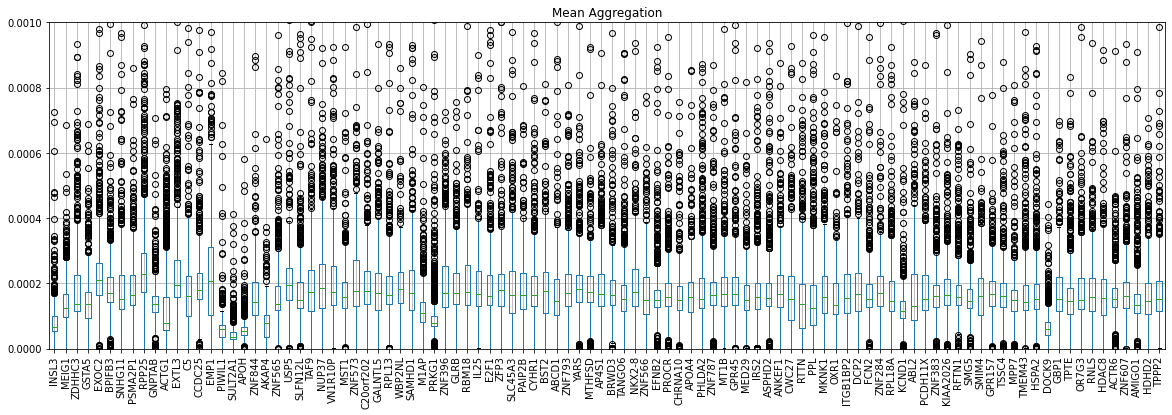

In [92]:
fig, ax = plt.subplots(figsize=(20, 6))
gdsc_attr[gdsc_attr_mean[:100]].boxplot(ax=ax, rot=90)
ax.set_title("Mean Aggregation")
ax.set_ylim(top=0.001, bottom=0)

(0.0, 0.001)

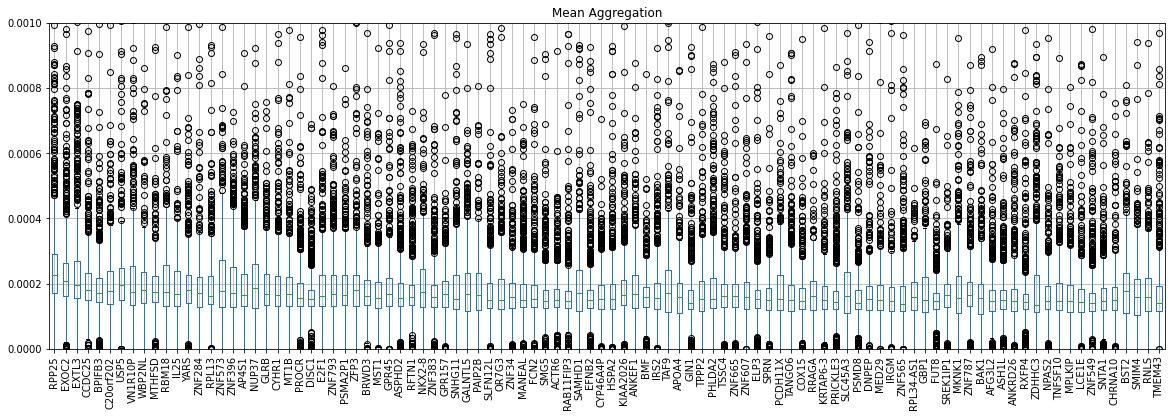

In [93]:
fig, ax = plt.subplots(figsize=(20, 6))
gdsc_attr[gdsc_borda[:100]].boxplot(ax=ax, rot=90)
ax.set_title("Mean Aggregation")
ax.set_ylim(top=0.001, bottom=0)

In [94]:
jacc_matrix = pd.DataFrame(index=['gdsc_borda', 'gdsc_mean', 'tcga_borda', 'tcga_mean'], columns=['gdsc_borda', 'gdsc_mean', 'tcga_borda', 'tcga_mean'])

In [110]:
top200 = pd.DataFrame(index=['gdsc_borda', 'gdsc_mean', 'tcga_borda', 'tcga_mean'], columns=dataset.hgnc, dtype=int)
top200.loc['gdsc_borda'] = gdsc_borda_onehot
top200.loc['gdsc_mean'] = gdsc_mean_onehot
top200.loc['tcga_borda'] = borda_onehot
top200.loc['tcga_mean'] = mean_onehot

In [111]:
for i in top200.index:
    for j in top200.index:
        jacc_matrix.at[i,j] = jaccard_score(top200.loc[i].values, top200.loc[j].values)

In [112]:
jacc_matrix

,gdsc_borda,gdsc_mean,tcga_borda,tcga_mean
gdsc_borda,1,0.550388,0.465201,0.365188
gdsc_mean,0.550388,1,0.428571,0.438849
tcga_borda,0.465201,0.428571,1,0.532567
tcga_mean,0.365188,0.438849,0.532567,1


**NOTE:** Many of the genes found in TCGA are also found in GDSC

In [115]:
spearmanr(attr.mean(axis=0), gdsc_attr.mean(axis=0))

SpearmanrResult(correlation=0.93282807239367, pvalue=0.0)

**NOTE:** mean attributions for GDSC and TCGA are highly correlated

In [118]:
print(spearmanr(attr[attr_mean].mean(axis=0), gdsc_attr[attr_mean].mean(axis=0)))
print(spearmanr(attr[gdsc_attr_mean].mean(axis=0), gdsc_attr[gdsc_attr_mean].mean(axis=0)))

SpearmanrResult(correlation=0.41585539638490965, pvalue=9.134226699697343e-10)
SpearmanrResult(correlation=0.2789979749493738, pvalue=6.317499579480979e-05)


**NOTE:**
 - Attributions for GDSC and TCGA Top 200 are correlated if attributions are filtered by top TCGA attribution mean  
 - Attributions for GDSC and TCGA Top 200 are less correlated if attributions are filtered by top GDSC attribution mean  

# Clustering Genes using TCGA Gene Expression

In [121]:
tcga_x = test_tcga_expr.T.values

In [129]:
tcga_x.shape

(15650, 20)

In [123]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

In [124]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

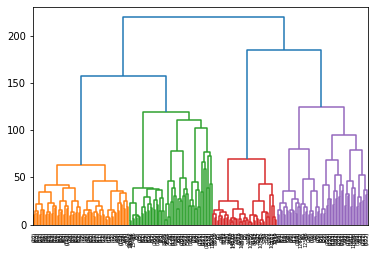

In [131]:
clust = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
clust = clust.fit(tcga_x)

plot_dendrogram(clust, truncate_mode='level', p=7)

In [139]:
clust = AgglomerativeClustering(n_clusters=4)
clust = clust.fit(tcga_x)

In [132]:
from sklearn.decomposition import PCA
gene_PCA = PCA(n_components=2).fit_transform(tcga_x)

In [135]:
from sklearn.manifold import TSNE
gene_TSNE = TSNE(n_components=2).fit_transform(tcga_x)

In [145]:
clusters = []
for i in range(4):
    clusters.append([j for j, s in enumerate(clust.labels_) if s == i])

In [158]:
tb = [i for i, j in enumerate(top200.loc['tcga_borda'] == 1) if j == 1]
tm = [i for i, j in enumerate(top200.loc['tcga_mean'] == 1) if j == 1]

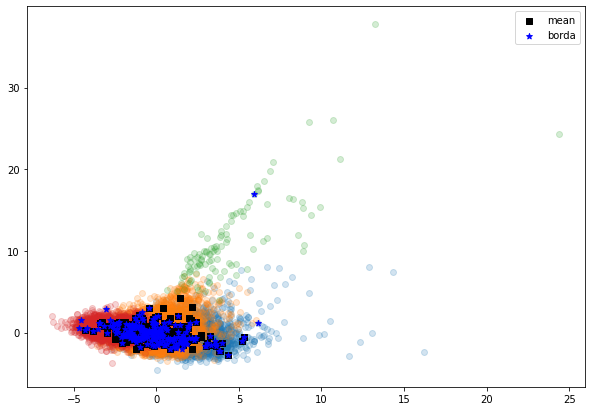

In [164]:
fix, ax = plt.subplots(figsize=(10,7))
for i in range(4):
    ax.scatter(gene_PCA[clusters[i],0], gene_PCA[clusters[i],1], alpha=0.2)

ax.scatter(gene_PCA[tm,0], gene_PCA[tm,1], alpha=1.0, marker='s', color='black', label='mean')
ax.scatter(gene_PCA[tb,0], gene_PCA[tb,1], alpha=1.0, marker='*', color='blue', label='borda')
plt.legend()
plt.show()

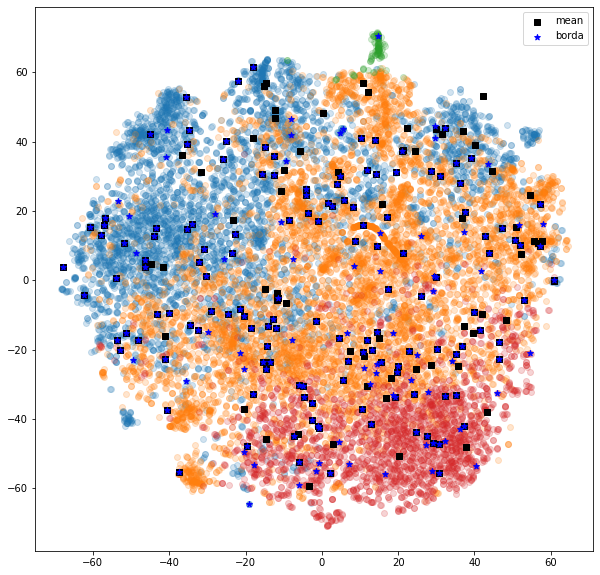

In [161]:
fix, ax = plt.subplots(figsize=(10,10))
for i in range(4):
    ax.scatter(gene_TSNE[clusters[i],0], gene_TSNE[clusters[i],1], alpha=0.2)

ax.scatter(gene_TSNE[tm,0], gene_TSNE[tm,1], alpha=1.0, marker='s', color='black', label='mean')
ax.scatter(gene_TSNE[tb,0], gene_TSNE[tb,1], alpha=1.0, marker='*', color='blue', label='borda')
plt.legend()
plt.show()

In [165]:
tcga_xb200 = test_tcga_expr[borda].T.values

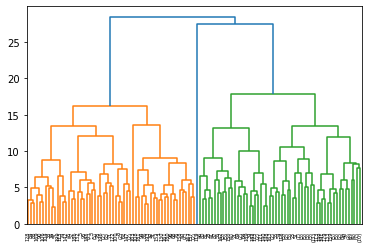

In [166]:
clust = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
clust = clust.fit(tcga_xb200)

plot_dendrogram(clust, truncate_mode='level', p=7)

In [167]:
clust = AgglomerativeClustering(n_clusters=3)
clust = clust.fit(tcga_xb200)

In [168]:
clusters = []
for i in range(3):
    clusters.append([j for j, s in enumerate(clust.labels_) if s == i])

In [172]:
gene_TSNE = TSNE(n_components=2).fit_transform(tcga_xb200)
tb = [i for i, j in enumerate(top200[borda].loc['tcga_borda'] == 1) if j == 1]
tm = [i for i, j in enumerate(top200[borda].loc['tcga_mean'] == 1) if j == 1]

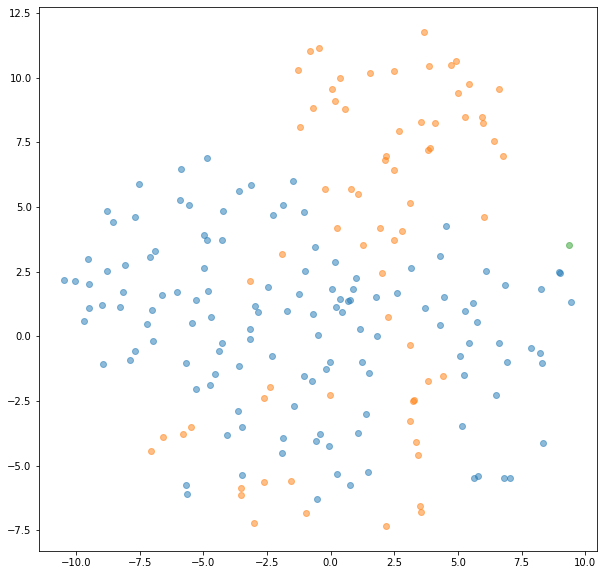

In [176]:
fix, ax = plt.subplots(figsize=(10,10))
for i in range(3):
    ax.scatter(gene_TSNE[clusters[i],0], gene_TSNE[clusters[i],1], alpha=0.5)
plt.show()